# Exploring Dandiset 001363: Neural Spiking Data in the Rat Somatosensory Cortex Using a Flexible Electrode Responding to Transcranial Focused Ultrasound

**⚠️ DISCLAIMER: This notebook was AI-generated using dandi-notebook-gen and has not been fully verified. Please be cautious when interpreting the code or results. ⚠️**

## Overview of the Dandiset

This Dandiset (DANDI:001363) contains neural spiking data recorded from the somatosensory cortex of rats using a flexible electrode while applying transcranial focused ultrasound stimulation (tFUS).

**Key features of the study:**

- Recordings were made using a chronically implanted ultraflexible nanoelectric thread electrode, allowing for the study of higher intensities of tFUS that would be impossible with rigid electrodes due to vibration artifacts
- The study tested different levels of in situ ultrasound pressure: 100, 400, 700, 1000, and 1300 kPa
- The researchers also tested varying duty cycles (0.6%, 6%, 30%, 60%, and 90%) while keeping pulse repetition frequency (PRF) constant at 1500 Hz
- They also tested varying PRFs (30, 300, 1500, 3000, and 4500 Hz) while maintaining a constant duty cycle of 30%
- Each recording contains 505 trials with ultrasound stimulation
- The fundamental frequency of ultrasound was 1500 kHz, and the ultrasound duration was 67 ms
- Trials were performed every 2 seconds with a jitter of 10%

You can explore this Dandiset further at: [https://neurosift.app/dandiset/001363](https://neurosift.app/dandiset/001363)

## What this notebook covers

In this notebook, we will:

1. Connect to the DANDI archive and access Dandiset 001363
2. Load and explore metadata from the NWB files
3. Examine the electrode configurations and properties
4. Analyze the trial structure and stimulation parameters
5. Visualize raw electrophysiology data from selected channels
6. Analyze neural activity around stimulation events
7. Compare responses across different channels

## Required packages

The following packages are required to run this notebook. Make sure you have them installed in your environment.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from dandi.dandiapi import DandiAPIClient
import pynwb
import h5py
import remfile
from scipy import signal
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec

# Set seaborn styling
sns.set_theme()

## Connecting to the DANDI archive

In [2]:
# Connect to the DANDI archive
client = DandiAPIClient()
dandiset = client.get_dandiset("001363")

# Get all assets in the Dandiset
assets = list(dandiset.get_assets())

print(f"Found {len(assets)} assets in the dataset")
print("\nFirst 5 assets:")
for asset in assets[:5]:
    print(f"- {asset.path}")

Found 55 assets in the dataset

First 5 assets:
- sub-BH643/sub-BH643_ecephys.nwb
- sub-BH643/sub-BH643_ses-20241220T182204_ecephys.nwb
- sub-BH643/sub-BH643_ses-20241220T174647_ecephys.nwb
- sub-BH643/sub-BH643_ses-20241220T195303_ecephys.nwb
- sub-BH643/sub-BH643_ses-20241220T180423_ecephys.nwb


Let's get some basic information about this Dandiset.

In [3]:
# Print Dandiset metadata - using get_raw_metadata() to avoid validation errors
metadata = dandiset.get_raw_metadata()
print(f"Dandiset name: {metadata.get('name', 'N/A')}")
print(f"Dandiset description: {metadata.get('description', 'N/A')}")
# Handle contributors which can be strings or dictionaries
contributors = metadata.get('contributor', [])
contributor_names = []
for contrib in contributors:
    if isinstance(contrib, str):
        contributor_names.append(contrib)
    elif isinstance(contrib, dict) and 'name' in contrib:
        contributor_names.append(contrib['name'])
    elif isinstance(contrib, dict):
        contributor_names.append(str(contrib))

print(f"Contributors: {', '.join(contributor_names)}")

# Handle variables measured
variables = metadata.get('variableMeasured', [])
variable_names = []
for var in variables:
    if isinstance(var, str):
        variable_names.append(var)
    elif isinstance(var, dict) and 'name' in var:
        variable_names.append(var['name'])
    elif isinstance(var, dict):
        variable_names.append(str(var))

print(f"Variables measured: {', '.join(variable_names)}")

# Print subject information from the first few assets
print("\nSubjects in the dataset:")
subjects = {}
for asset in assets[:20]:  # Check first 20 assets to find unique subjects
    subject_id = asset.path.split('/')[0].split('-')[1]
    if subject_id not in subjects:
        subjects[subject_id] = asset.path.split('/')[0]

for subject_id, full_id in subjects.items():
    print(f"- {full_id}")

Dandiset name: Neural Spiking Data in the Rat Somatosensory Cortex Using a Flexible Electrode Responding to Transcranial Focused Ultrasound
Dandiset description: In this study, we investigate the neuronal response to transcranial focused ultrasound stimulation (tFUS) on the somatosensory cortex using a 128-element array transducer and a chronically implanted ultraflexible nanoelectric thread electrode. This flexible electrode allows us to  study higher intensities of tFUS which are impossible with a rigid electrode due to the vibration artifacts that are created. Here we test 5 different levels of in situ ultrasound pressure including 100, 400, 700, 1000, and 1300 kPa. We then tested the effect of varying duty cycle while keeping the pulse repetition frequency (PRF) constant while using the highest peak-peak pressure (1300 kPa), testing duty cycles of 0.6%, 6%, 30%, 60%, and 90% while holding PRF at 1500 Hz. Finally we tested the effect of varying PRF while holding duty cycle constant,

## Loading and exploring an NWB file

Let's load one of the NWB files to explore its structure. We'll select a file from subject BH589.

In [4]:
# URL for the specific NWB file we'll analyze
url = "https://api.dandiarchive.org/api/assets/59d1acbb-5ad5-45f1-b211-c2e311801824/download/"

# Load the NWB file using remfile to stream it remotely
remote_file = remfile.File(url)
h5_file = h5py.File(remote_file)
io = pynwb.NWBHDF5IO(file=h5_file)
nwb = io.read()

# Print basic information about the file
print(f"Session description: {nwb.session_description}")
print(f"Identifier: {nwb.identifier}")
print(f"Session start time: {nwb.session_start_time}")
print(f"Institution: {nwb.institution}")

Session description: Rat Ultrasound Array Stimulation
Identifier: BH589_1500_200_67_25V
Session start time: 2024-08-27 16:04:57-04:00
Institution: Carnegie Mellon University


/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


### Subject information

In [5]:
# Get information about the subject
subject = nwb.subject
print(f"Subject ID: {subject.subject_id}")
print(f"Species: {subject.species}")
print(f"Sex: {subject.sex}")
print(f"Age: {subject.age} ({subject.age__reference})")
print(f"Description: {subject.description}")

Subject ID: BH589
Species: Rattus norvegicus
Sex: M
Age: P24W (birth)
Description: HSD:WI rat


### Exploring electrode information

Let's examine the electrodes used for recording.

In [6]:
# Get electrode information
electrodes_df = nwb.electrodes.to_dataframe()
print(f"Number of electrodes: {len(electrodes_df)}")

# Display the first few electrodes
electrodes_df.head()

Number of electrodes: 32


,x,y,z,imp,location,filtering,group,group_name
id,,,,,,,,
0,24.73,0.0,0.0,NaN,unknown,unknown,shank1 pynwb.ecephys.ElectrodeGroup at 0x14030...,shank1elec1
1,0.00,25.0,0.0,NaN,unknown,unknown,shank1 pynwb.ecephys.ElectrodeGroup at 0x14030...,shank1elec2
2,24.73,50.0,0.0,NaN,unknown,unknown,shank1 pynwb.ecephys.ElectrodeGroup at 0x14030...,shank1elec3
3,0.00,75.0,0.0,NaN,unknown,unknown,shank1 pynwb.ecephys.ElectrodeGroup at 0x14030...,shank1elec4
4,24.73,100.0,0.0,NaN,unknown,unknown,shank1 pynwb.ecephys.ElectrodeGroup at 0x14030...,shank1elec5


Let's look at the electrode grouping information.

In [7]:
# Get electrode group information
for group_name, group in nwb.electrode_groups.items():
    print(f"\nGroup name: {group_name}")
    print(f"Description: {group.description}")
    print(f"Location: {group.location}")
    print(f"Device description: {group.device.description}")
    print(f"Device manufacturer: {group.device.manufacturer}")


Group name: shank1
Description: electrode group for shank1
Location: brain area
Device description: NET probe flexible electrode
Device manufacturer: Xie Lab Rice University


### Exploring trial information

The experiment consists of multiple trials where transcranial focused ultrasound (tFUS) was applied. 
Let's examine the trial structure.

Number of trials: 500

First 5 trials (start and stop times in seconds):
    start_time  stop_time
id                       
1     0.341402   1.841402
2     2.816532   4.316532
3     5.115003   6.615003
4     7.458079   8.958079
5     9.984000  11.484000

Trial duration statistics (seconds):
count    5.000000e+02
mean     1.500000e+00
std      7.167895e-16
min      1.500000e+00
25%      1.500000e+00
50%      1.500000e+00
75%      1.500000e+00
max      1.500000e+00
Name: duration, dtype: float64


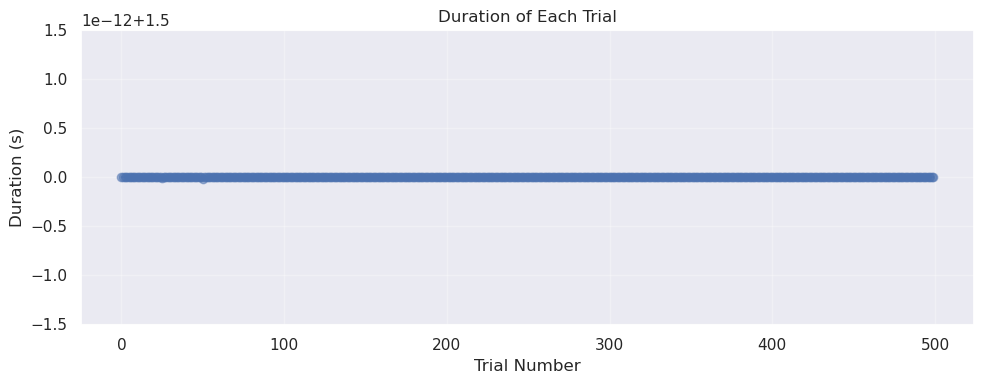

In [8]:
# Get trial information
trials_df = nwb.trials.to_dataframe()
print(f"Number of trials: {len(trials_df)}")

# Display the first few trials
print("\nFirst 5 trials (start and stop times in seconds):")
print(trials_df.head())

# Calculate trial durations
trials_df['duration'] = trials_df['stop_time'] - trials_df['start_time']

# Summary statistics for trial durations
print("\nTrial duration statistics (seconds):")
print(trials_df['duration'].describe())

# Plot trial durations
plt.figure(figsize=(10, 4))
plt.plot(trials_df['duration'].values, 'o-', alpha=0.5)
plt.xlabel('Trial Number')
plt.ylabel('Duration (s)')
plt.title('Duration of Each Trial')
plt.grid(True, alpha=0.3)
plt.tight_layout()

### Exploring the electrophysiology data

Let's examine the structure of the electrophysiology data.

In [9]:
# Get information about the electrical series
electrical_series = nwb.acquisition["ElectricalSeries"]
print(f"Data dimensions: {electrical_series.data.shape}")
print(f"Sampling rate: {electrical_series.rate} Hz")
print(f"Starting time: {electrical_series.starting_time} {electrical_series.starting_time_unit}")
print(f"Unit: {electrical_series.unit}")

# Calculate recording duration
num_samples = electrical_series.data.shape[0]
duration_seconds = num_samples / electrical_series.rate
print(f"Recording duration: {duration_seconds:.2f} seconds ({duration_seconds/60:.2f} minutes)")

Data dimensions: (31084544, 32)
Sampling rate: 24414.0625 Hz
Starting time: 0.0 seconds
Unit: volts
Recording duration: 1273.22 seconds (21.22 minutes)


## Visualizing electrophysiology data

Now let's visualize some of the electrophysiology data. Since the dataset is large and stored remotely, 
we'll load a small subset of the data to visualize.

Loaded data shape: (24414, 32)
Time window: 0.00s - 1.00s


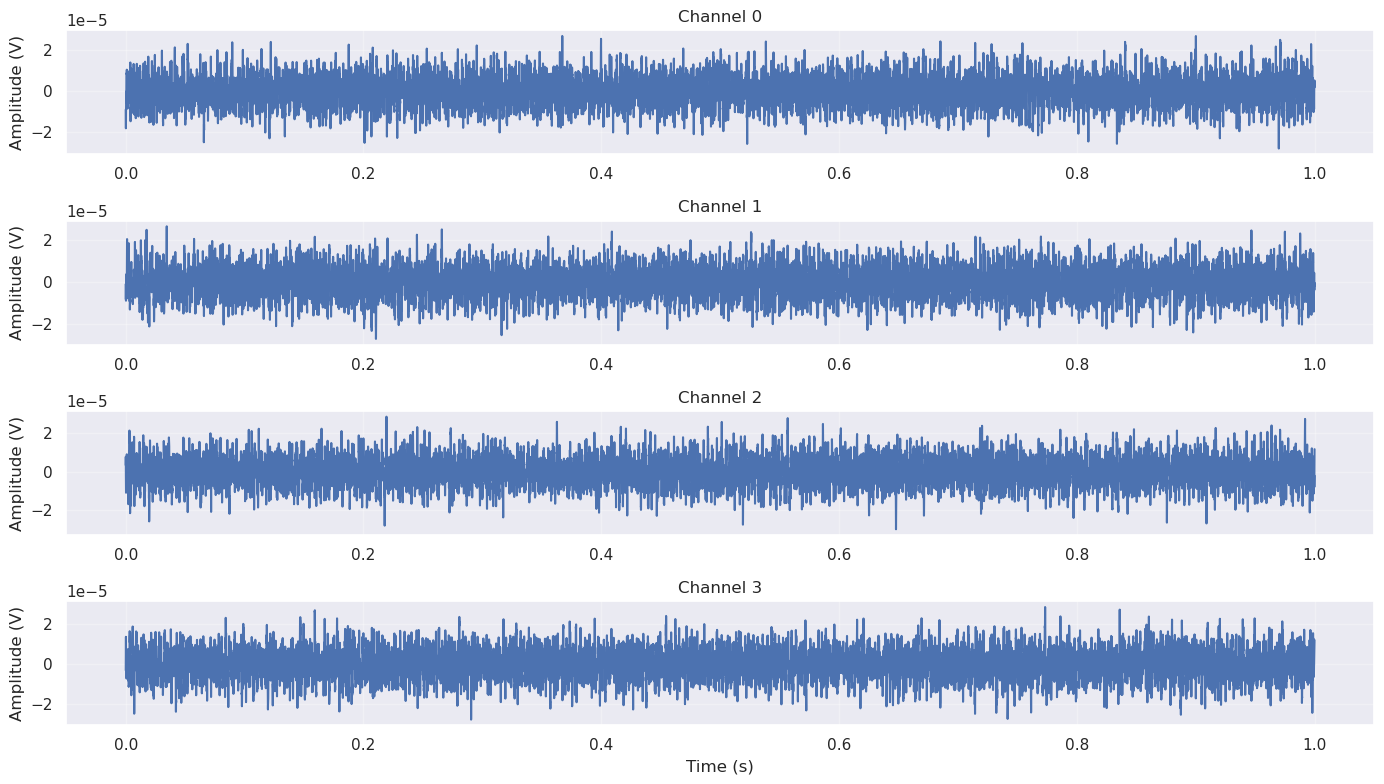

In [10]:
# Extract a small segment of data from the beginning of the recording
# Using a 1-second window (sampling rate is about 24414 Hz)
segment_duration = 1  # seconds
num_samples_to_load = int(electrical_series.rate * segment_duration)
start_sample = 0

# Load a subset of data from all channels
data_subset = electrical_series.data[start_sample:start_sample+num_samples_to_load, :]

print(f"Loaded data shape: {data_subset.shape}")
print(f"Time window: {start_sample/electrical_series.rate:.2f}s - {(start_sample+num_samples_to_load)/electrical_series.rate:.2f}s")

# Create a time axis
time_axis = np.arange(data_subset.shape[0]) / electrical_series.rate

# Plot the first 4 channels
plt.figure(figsize=(14, 8))
for i in range(4):
    plt.subplot(4, 1, i+1)
    plt.plot(time_axis, data_subset[:, i])
    plt.title(f'Channel {i}')
    plt.ylabel('Amplitude (V)')
    if i == 3:  # Only add x-label to the bottom plot
        plt.xlabel('Time (s)')
    plt.grid(True, alpha=0.3)
plt.tight_layout()

Now, let's visualize the data from all 32 channels in a heatmap to get an overview of the activity patterns.

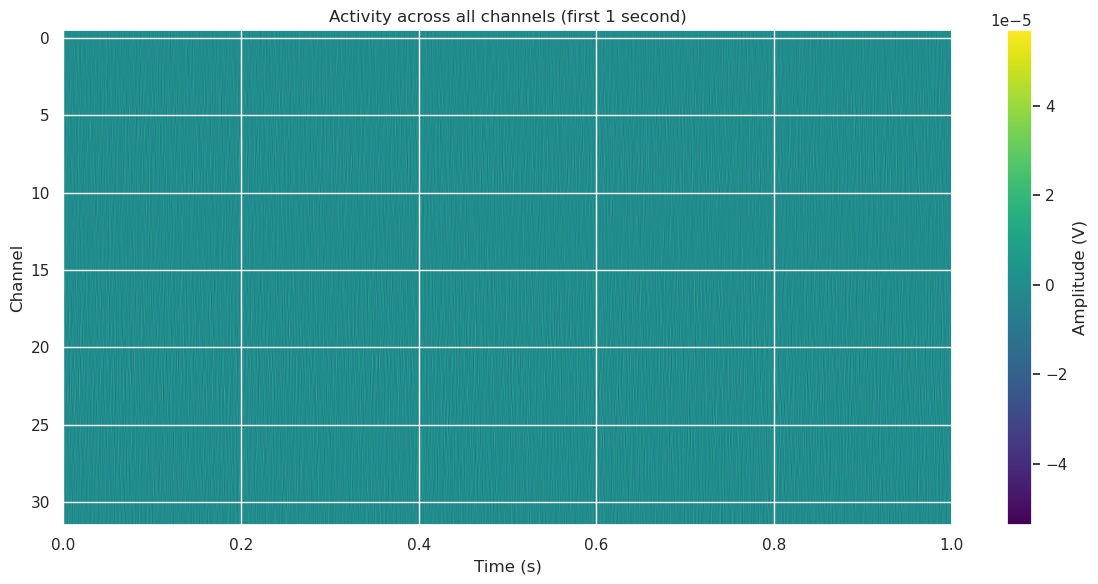

In [11]:
# Create a heatmap of all channels
plt.figure(figsize=(12, 6))
plt.imshow(data_subset.T, aspect='auto', cmap='viridis', 
           extent=[0, segment_duration, 31.5, -0.5])
plt.colorbar(label='Amplitude (V)')
plt.xlabel('Time (s)')
plt.ylabel('Channel')
plt.title('Activity across all channels (first 1 second)')
plt.tight_layout()

## Analyzing neural responses to stimulation

Now let's analyze the neural activity around the stimulation events. We'll look at how the neural activity changes
before, during, and after the tFUS stimulation.

In [12]:
# Let's look at the first trial
trial_start_time = trials_df['start_time'].iloc[0]
trial_stop_time = trials_df['stop_time'].iloc[0]
print(f"First trial: start={trial_start_time:.2f}s, stop={trial_stop_time:.2f}s, duration={trial_stop_time-trial_start_time:.2f}s")

# Define a window around the trial (0.5s before to 0.5s after)
pre_window = 0.5  # seconds before trial start
post_window = 0.5  # seconds after trial end

# Convert time to sample indices
start_sample = int((trial_start_time - pre_window) * electrical_series.rate)
stop_sample = int((trial_stop_time + post_window) * electrical_series.rate)

# Make sure we don't go out of bounds
start_sample = max(0, start_sample)
stop_sample = min(electrical_series.data.shape[0], stop_sample)

# Load data around the first trial
trial_data = electrical_series.data[start_sample:stop_sample, :]
print(f"Loaded trial data shape: {trial_data.shape}")

# Create a time axis relative to trial start
trial_time_axis = np.arange(trial_data.shape[0]) / electrical_series.rate + (start_sample / electrical_series.rate) - trial_start_time

First trial: start=0.34s, stop=1.84s, duration=1.50s
Loaded trial data shape: (57163, 32)


Let's visualize the neural activity around the first stimulation trial.

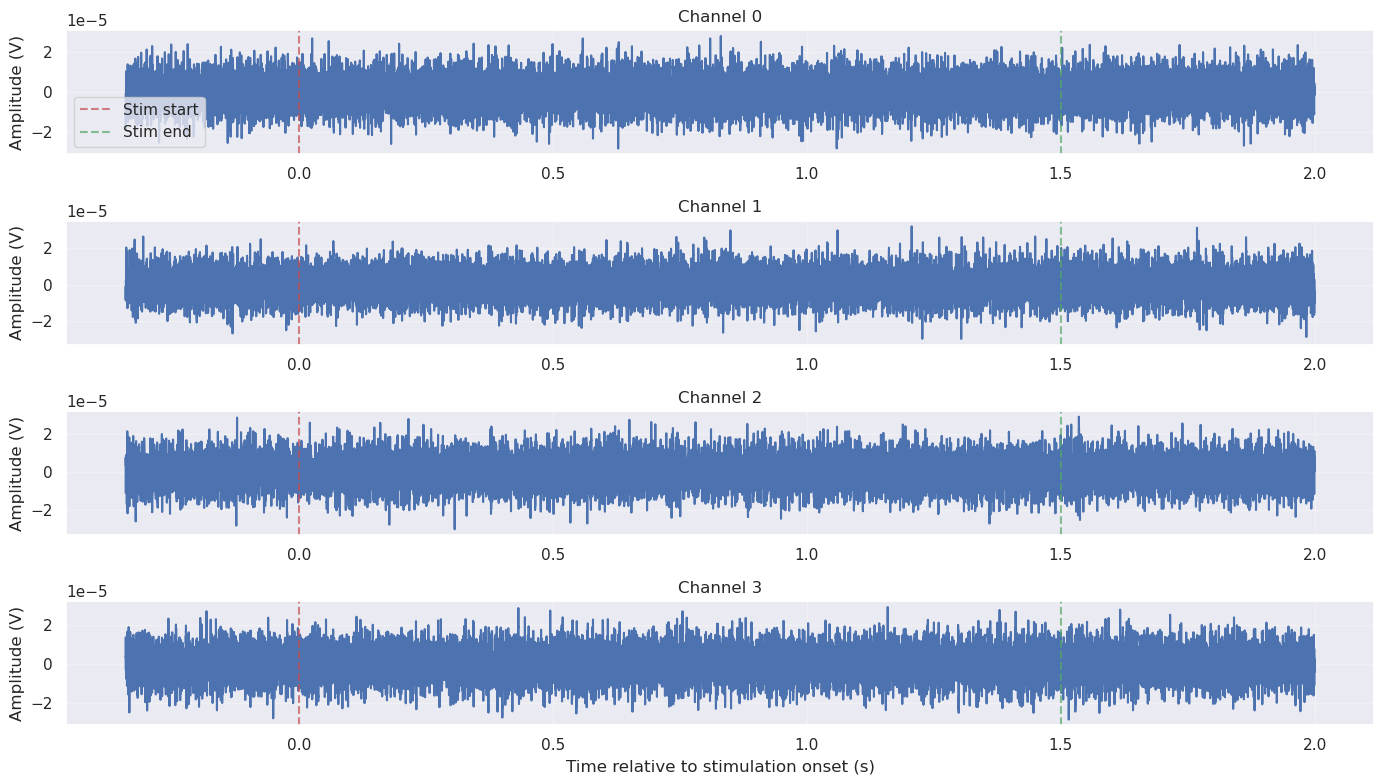

In [13]:
# Plot data from 4 channels around the stimulation event
plt.figure(figsize=(14, 8))
for i in range(4):
    plt.subplot(4, 1, i+1)
    plt.plot(trial_time_axis, trial_data[:, i])
    plt.axvline(0, color='r', linestyle='--', alpha=0.7, label='Stim start')
    plt.axvline(trial_stop_time - trial_start_time, color='g', linestyle='--', alpha=0.7, label='Stim end')
    plt.title(f'Channel {i}')
    plt.ylabel('Amplitude (V)')
    # Add legend to the first plot only to avoid clutter
    if i == 0:
        plt.legend()
    if i == 3:  # Only add x-label to the bottom plot
        plt.xlabel('Time relative to stimulation onset (s)')
    plt.grid(True, alpha=0.3)
plt.tight_layout()

Now let's look at all channels as a heatmap to visualize the response patterns across the electrode array.

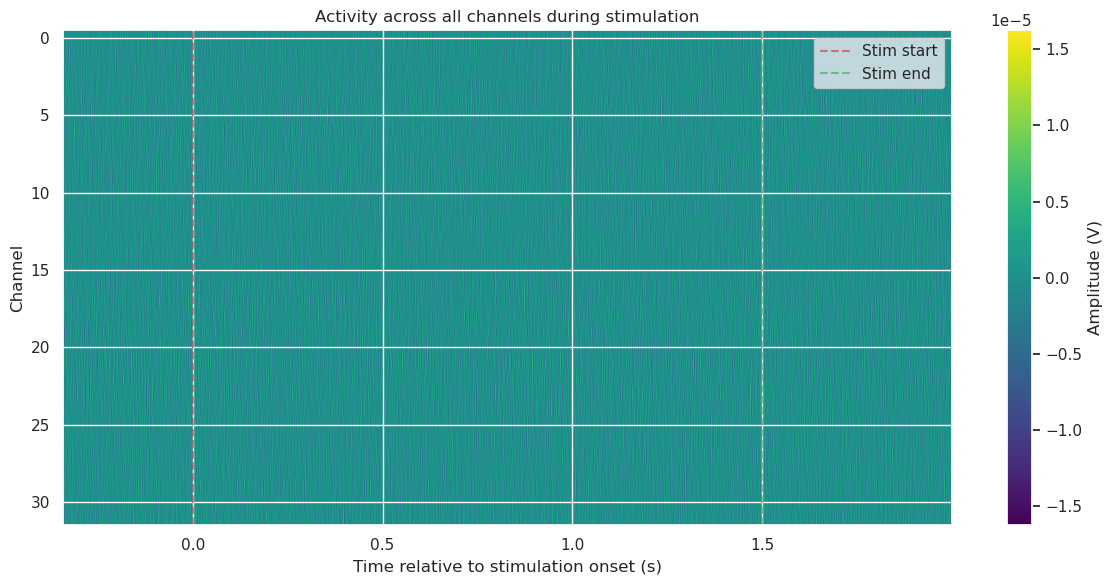

In [14]:
# Create a heatmap of all channels around the stimulation
plt.figure(figsize=(12, 6))

# Normalize data for better visualization
vmin = np.percentile(trial_data, 5)
vmax = np.percentile(trial_data, 95)

plt.imshow(trial_data.T, aspect='auto', cmap='viridis', 
           extent=[trial_time_axis[0], trial_time_axis[-1], 31.5, -0.5],
           vmin=vmin, vmax=vmax)
plt.colorbar(label='Amplitude (V)')
plt.axvline(0, color='r', linestyle='--', alpha=0.7, label='Stim start')
plt.axvline(trial_stop_time - trial_start_time, color='g', linestyle='--', alpha=0.7, label='Stim end')
plt.xlabel('Time relative to stimulation onset (s)')
plt.ylabel('Channel')
plt.title('Activity across all channels during stimulation')
plt.legend()
plt.tight_layout()

### Analyzing frequency components

Let's also analyze the frequency components of the neural activity before and during stimulation.

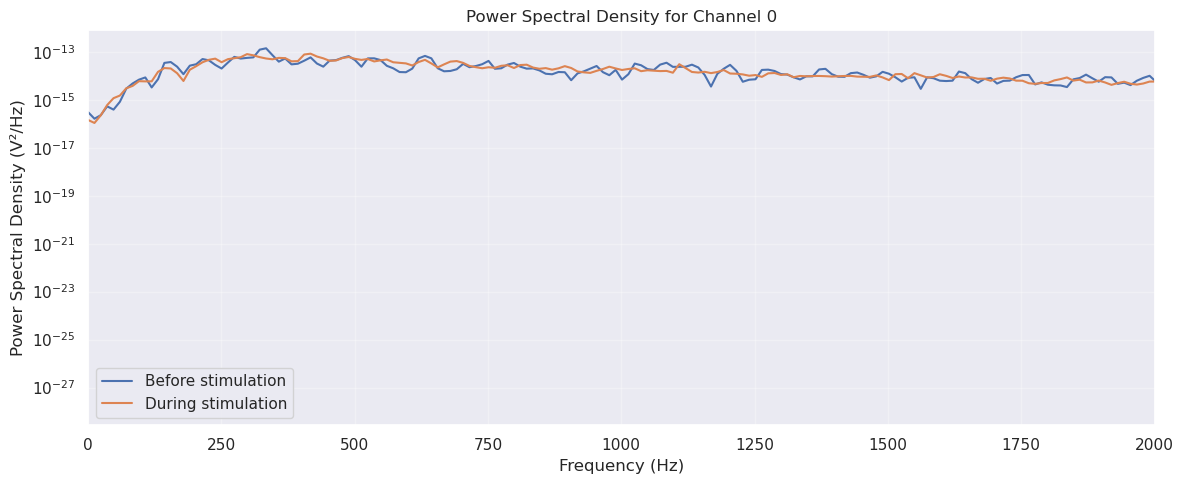

In [15]:
# Calculate spectrograms for a selected channel
channel = 0  # Select first channel for analysis

# Define windows for before and during stimulation
pre_stim_start = start_sample
pre_stim_end = int(trial_start_time * electrical_series.rate)
during_stim_start = int(trial_start_time * electrical_series.rate)
during_stim_end = int(trial_stop_time * electrical_series.rate)

# Ensure we have enough data for analysis
if pre_stim_end > pre_stim_start and during_stim_end > during_stim_start:
    # Load data for selected periods
    pre_stim_data = electrical_series.data[pre_stim_start:pre_stim_end, channel]
    during_stim_data = electrical_series.data[during_stim_start:during_stim_end, channel]
    
    # Calculate power spectral density
    fs = electrical_series.rate
    f_pre, pxx_pre = signal.welch(pre_stim_data, fs, nperseg=2048)
    f_during, pxx_during = signal.welch(during_stim_data, fs, nperseg=2048)
    
    # Plot power spectral density
    plt.figure(figsize=(12, 5))
    plt.semilogy(f_pre, pxx_pre, label='Before stimulation')
    plt.semilogy(f_during, pxx_during, label='During stimulation')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density (V²/Hz)')
    plt.title(f'Power Spectral Density for Channel {channel}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xlim(0, 2000)  # Limit frequency range for better visualization
    plt.tight_layout()

### Average response to stimulation

Let's calculate the average response to stimulation across multiple trials to identify consistent patterns.

In [16]:
# Number of trials to average
num_trials_to_analyze = min(10, len(trials_df))

# Time window around stimulation onset (in seconds)
window_before = 0.5
window_after = 1.0

# Sample count for the window
samples_before = int(window_before * electrical_series.rate)
samples_after = int(window_after * electrical_series.rate)
total_samples = samples_before + samples_after

# Initialize array to hold data from all trials
all_trials_data = np.zeros((num_trials_to_analyze, total_samples, 4))  # Using first 4 channels

# Collect data around stimulation onset for multiple trials
for i in range(num_trials_to_analyze):
    stim_onset_time = trials_df['start_time'].iloc[i]
    onset_sample = int(stim_onset_time * electrical_series.rate)
    
    # Define window around stimulation onset
    start_sample = onset_sample - samples_before
    end_sample = onset_sample + samples_after
    
    # Make sure we don't go out of bounds
    if start_sample >= 0 and end_sample < electrical_series.data.shape[0]:
        # Extract data for first 4 channels
        trial_window_data = electrical_series.data[start_sample:end_sample, :4]
        
        # Store data if it's the right shape
        if trial_window_data.shape[0] == total_samples:
            all_trials_data[i] = trial_window_data

# Calculate average response
avg_response = np.mean(all_trials_data, axis=0)

# Create time axis relative to stimulation onset
time_axis = np.linspace(-window_before, window_after, total_samples)

Now let's plot the average response for the first 4 channels.

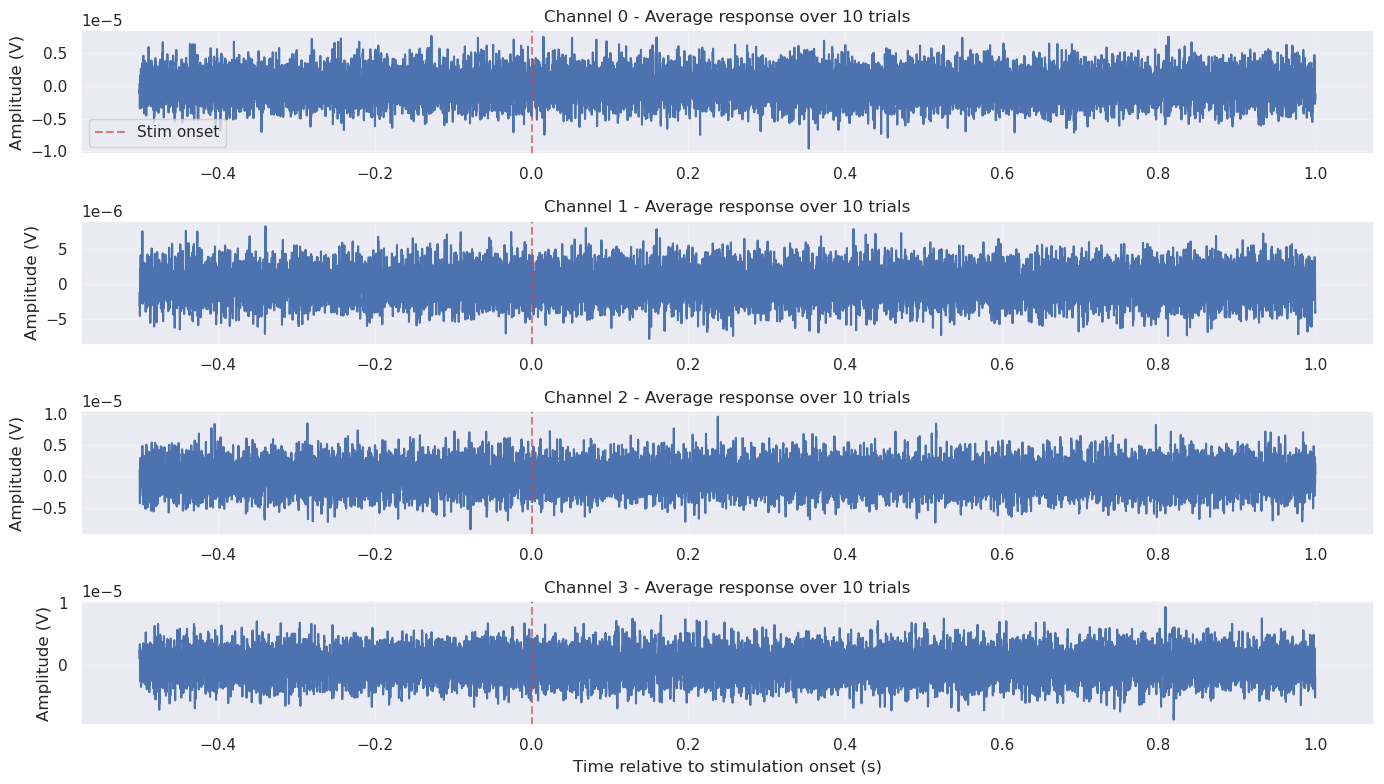

In [17]:
# Plot average response for the first 4 channels
plt.figure(figsize=(14, 8))
for i in range(4):
    plt.subplot(4, 1, i+1)
    plt.plot(time_axis, avg_response[:, i])
    plt.axvline(0, color='r', linestyle='--', alpha=0.7, label='Stim onset')
    plt.title(f'Channel {i} - Average response over {num_trials_to_analyze} trials')
    plt.ylabel('Amplitude (V)')
    
    if i == 0:
        plt.legend()
    if i == 3:
        plt.xlabel('Time relative to stimulation onset (s)')
        
    plt.grid(True, alpha=0.3)
plt.tight_layout()

## Trial-to-trial variability

Let's examine the variability in responses across trials.

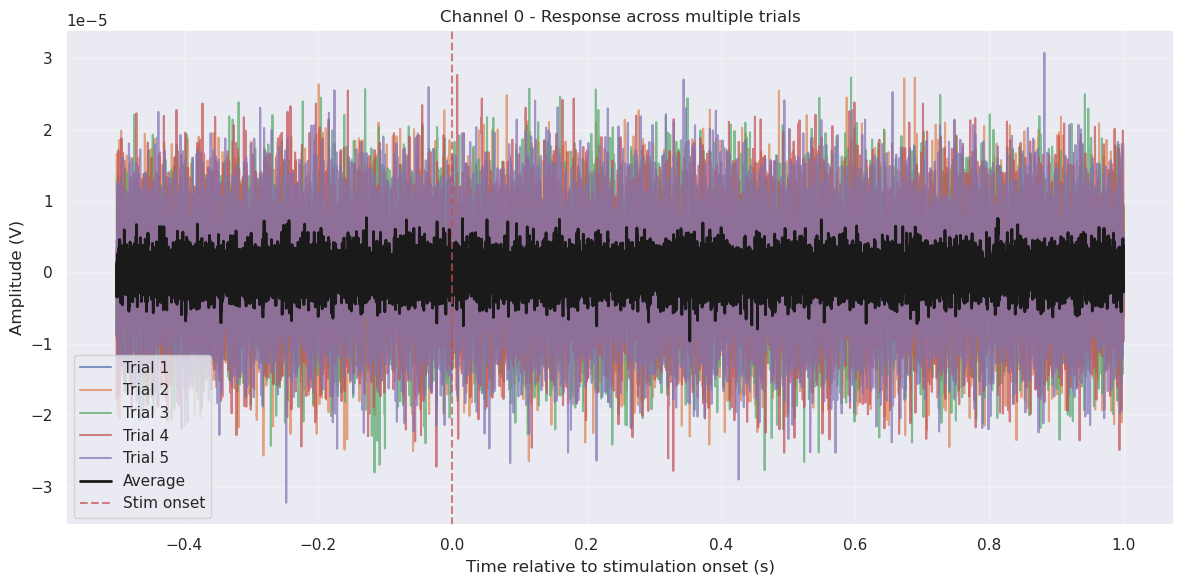

In [18]:
# Plot multiple trials for one channel to show variability
channel_to_plot = 0  # First channel

plt.figure(figsize=(12, 6))
for i in range(min(5, num_trials_to_analyze)):  # Plot first 5 trials
    plt.plot(time_axis, all_trials_data[i, :, channel_to_plot], alpha=0.7, label=f'Trial {i+1}')

plt.plot(time_axis, avg_response[:, channel_to_plot], 'k', linewidth=2, label='Average')
plt.axvline(0, color='r', linestyle='--', alpha=0.7, label='Stim onset')
plt.title(f'Channel {channel_to_plot} - Response across multiple trials')
plt.xlabel('Time relative to stimulation onset (s)')
plt.ylabel('Amplitude (V)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

## Summary

In this notebook, we've explored Dandiset 001363, which contains neural spiking data from rat somatosensory cortex recorded using flexible electrodes while applying transcranial focused ultrasound stimulation.

We've examined:

1. The dataset structure and metadata
2. Subject and electrode information
3. Trial structure and timing
4. Raw electrophysiology data visualization
5. Neural activity patterns around stimulation events
6. Spectral characteristics before and during stimulation
7. Average responses and trial-to-trial variability

This dataset provides valuable insights into how neurons in the somatosensory cortex respond to focused ultrasound stimulation, which has potential applications in non-invasive neuromodulation techniques.

## Future directions

There are many more analyses that could be performed with this rich dataset:

- Compare responses across different ultrasound pressure levels (100-1300 kPa)
- Analyze the effects of varying duty cycles and pulse repetition frequencies
- Perform spike detection and sorting to isolate individual neuron responses
- Investigate the spatial patterns of activity across the electrode array
- Compare responses across different subjects
- Apply more advanced signal processing and machine learning techniques to characterize response patterns
- Correlate neural responses with specific ultrasound parameters to optimize stimulation protocols